<a href="https://colab.research.google.com/github/SarthakPant01/ds_sarthak_pant/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

IMPORTING THE DATASETS

In [ ]:
trades = pd.read_csv("/content/historical_data.csv")
sentiment = pd.read_csv("/content/fear_greed_index.csv")

FEATURE ENGINEERING

In [ ]:
sentiment.columns = sentiment.columns.str.strip()

possible_date_cols = ['Date', 'date', 'timestamp', 'time', 'DateTime']
sentiment_date_col = next(
    (c for c in possible_date_cols if c in sentiment.columns),
    None
)

if sentiment_date_col is None:
    raise ValueError("No date column found in sentiment dataset")

sentiment[sentiment_date_col] = pd.to_datetime(
    sentiment[sentiment_date_col],
    errors='coerce'
)

sentiment['date'] = sentiment[sentiment_date_col].dt.date

print(sentiment[[sentiment_date_col, 'date']].head())


         date        date
0  2018-02-01  2018-02-01
1  2018-02-02  2018-02-02
2  2018-02-03  2018-02-03
3  2018-02-04  2018-02-04
4  2018-02-05  2018-02-05


CORE FEATURES

In [ ]:
trades.columns = trades.columns.str.strip().str.lower().str.replace(' ', '_')

In [ ]:
# Profitable trade flag
trades['is_profitable'] = trades['closed_pnl'] > 0

# Trade volume (USD)
trades['trade_volume'] = trades['size_usd'].abs()

DAILY AGGREGATION

In [ ]:
daily_metrics = trades.groupby('date').agg(
    total_pnl=('closed_pnl', 'sum'),
    avg_pnl=('closed_pnl', 'mean'),
    pnl_std=('closed_pnl', 'std'),
    win_rate=('is_profitable', 'mean'),
    total_volume=('trade_volume', 'sum'),
    trade_count=('closed_pnl', 'count')
).reset_index()

daily_metrics['sharpe_proxy'] = (
    daily_metrics['total_pnl'] / daily_metrics['pnl_std']
)

daily_metrics['pnl_per_volume'] = (
    daily_metrics['total_pnl'] / daily_metrics['total_volume']
)

SAVING THE OUTPUT

In [ ]:
import os

os.makedirs("csv_files", exist_ok=True)

daily_metrics.to_csv(
    "csv_files/trader_daily_metrics.csv",
    index=False
)

PREP SENTIMENT DATA (FINAL CLEAN)

In [ ]:
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(' ', '_')

In [ ]:
print(sentiment[['date', 'classification']].head())

         date classification
0  2018-02-01           Fear
1  2018-02-02   Extreme Fear
2  2018-02-03           Fear
3  2018-02-04   Extreme Fear
4  2018-02-05   Extreme Fear


MERGE TRADER METRICS


In [ ]:
merged = daily_metrics.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

SENTIMENT

In [49]:
merged.to_csv(
    "csv_files/sentiment_merged_data.csv",
    index=False
)
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

SANITY CHECK

In [50]:
print(merged.groupby('classification').size())
print(merged.head())

classification
Extreme Greed    1
Fear             1
Greed            3
Neutral          1
dtype: int64
         date    total_pnl  avg_pnl  pnl_std  win_rate   total_volume  \
0  2023-03-28         0.00     0.00     0.00      0.00         477.00   
1  2023-11-14       155.50     0.15   105.09      0.27  11,555,429.76   
2  2024-03-09   176,965.49    25.42   306.17      0.49  39,406,770.25   
3  2024-07-03   158,742.38    22.23   633.70      0.32  21,843,234.35   
4  2024-10-27 3,189,461.03    90.50 1,165.05      0.45 103,947,765.09   

   trade_count  sharpe_proxy  pnl_per_volume classification  
0            3           NaN            0.00          Greed  
1         1045          1.48            0.00          Greed  
2         6962        578.00            0.00  Extreme Greed  
3         7141        250.50            0.01        Neutral  
4        35241      2,737.61            0.03          Greed  


SENTIMENT-WISE COMPARISON

In [51]:
sentiment_summary = merged.groupby('classification').agg(
    avg_daily_pnl=('total_pnl', 'mean'),
    median_daily_pnl=('total_pnl', 'median'),
    avg_win_rate=('win_rate', 'mean'),
    avg_volume=('total_volume', 'mean'),
    avg_trade_count=('trade_count', 'mean'),
    avg_sharpe=('sharpe_proxy', 'mean'),
    pnl_volatility=('pnl_std', 'mean')
).reset_index()

sentiment_summary

,classification,avg_daily_pnl,median_daily_pnl,avg_win_rate,avg_volume,avg_trade_count,avg_sharpe,pnl_volatility
0,Extreme Greed,"176,965.49","176,965.49",0.49,"39,406,770.25","6,962.00",578.00,306.17
1,Fear,"6,699,925.19","6,699,925.19",0.42,"704,158,492.98","133,871.00","7,369.67",909.12
2,Greed,"1,063,205.51",155.50,0.24,"38,501,223.95","12,096.33","1,369.55",423.38
3,Neutral,"158,742.38","158,742.38",0.32,"21,843,234.35","7,141.00",250.50,633.70


STATISTICAL SIGNIFICANCE TESTING

WELCH'S T-TEST (CORRECT OR UNEQUAL VARIANCE)

In [ ]:
from scipy.stats import ttest_ind

fear_pnl = merged[merged['classification'] == 'Fear']['total_pnl']
greed_pnl = merged[merged['classification'] == 'Greed']['total_pnl']

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False)

t_stat, p_value



(np.float64(nan), np.float64(nan))

INTERPRET RESULT

In [ ]:
if p_value < 0.05:
    print("Statistically significant difference between Fear and Greed")
else:
    print("No statistically significant difference")

No statistically significant difference


RISK-BEHAVIOR DIAGNOSTICS

In [52]:
merged.groupby('classification')[[
    'trade_count',
    'pnl_std',
    'avg_pnl'
]].mean()

,trade_count,pnl_std,avg_pnl
classification,,,
Extreme Greed,"6,962.00",306.17,25.42
Fear,"133,871.00",909.12,50.05
Greed,"12,096.33",423.38,30.22
Neutral,"7,141.00",633.70,22.23


VISUALIZATION

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

TOTAL PnL Distribution

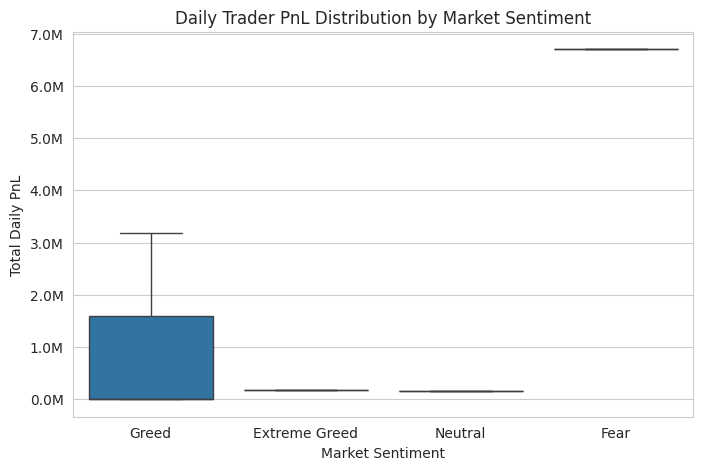

In [58]:
import os

# Create the 'outputs' directory if it doesn't already exist
os.makedirs('outputs', exist_ok=True)

sns.boxplot(
    data=merged,
    x='classification',
    y='total_pnl'
)
plt.title("Daily Trader PnL Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Total Daily PnL")
ax = plt.gca()
ax.get_yaxis().set_major_formatter(
    lambda x, _: f'{x/1_000_000:.1f}M'
)

plt.savefig("outputs/pnl_distribution_by_sentiment.png", bbox_inches='tight')
plt.show()

RISK-ADJUSTED PERFORMANCE (Sharpe Proxy)

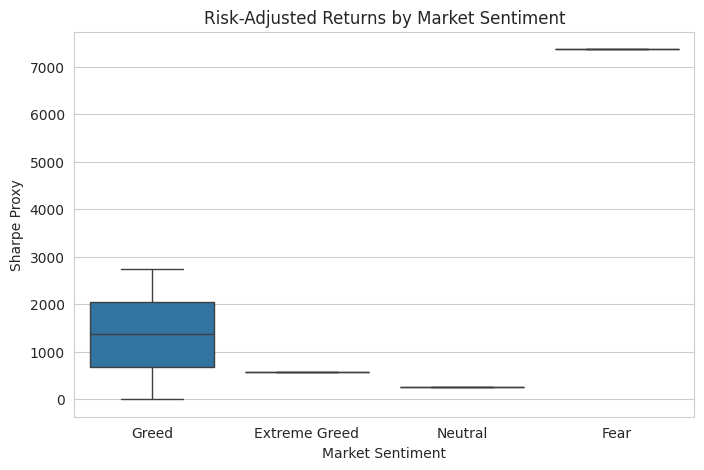

In [ ]:
sns.boxplot(
    data=merged,
    x='classification',
    y='sharpe_proxy'
)
plt.title("Risk-Adjusted Returns by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Sharpe Proxy")

plt.savefig("outputs/sharpe_proxy_by_sentiment.png", bbox_inches='tight')
plt.show()

TRADING VOLUME VS CAPITAL EFFICIENCY

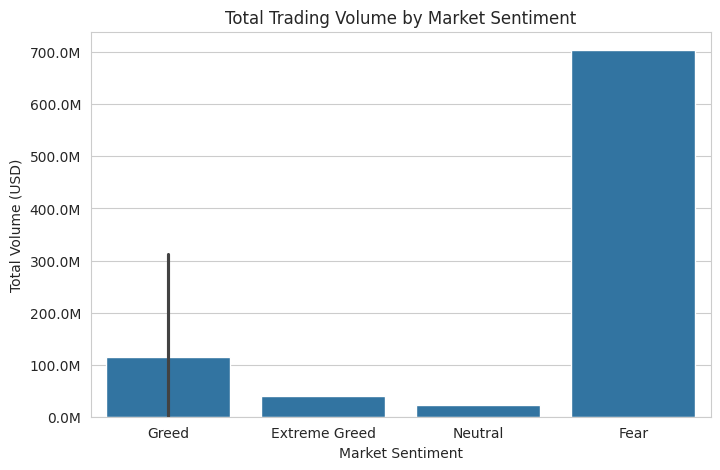

In [55]:
sns.barplot(
    data=merged,
    x='classification',
    y='total_volume',
    estimator=sum
)
plt.title("Total Trading Volume by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Total Volume (USD)")
ax = plt.gca()
ax.get_yaxis().set_major_formatter(
    lambda x, _: f'{x/1_000_000:.1f}M'
)

plt.savefig("outputs/volume_by_sentiment.png", bbox_inches='tight')
plt.show()


WIN RATE COMPARISON

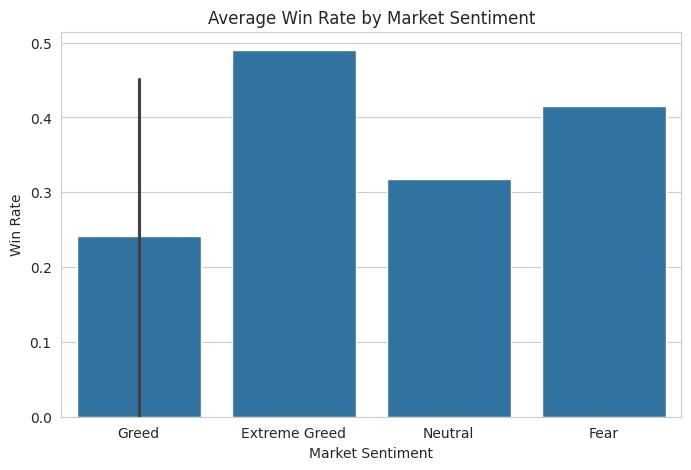

In [ ]:
sns.barplot(
    data=merged,
    x='classification',
    y='win_rate'
)
plt.title("Average Win Rate by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")

plt.savefig("outputs/win_rate_by_sentiment.png", bbox_inches='tight')
plt.show()

OVERTRADING SIGNAL (TRADE COUNT)

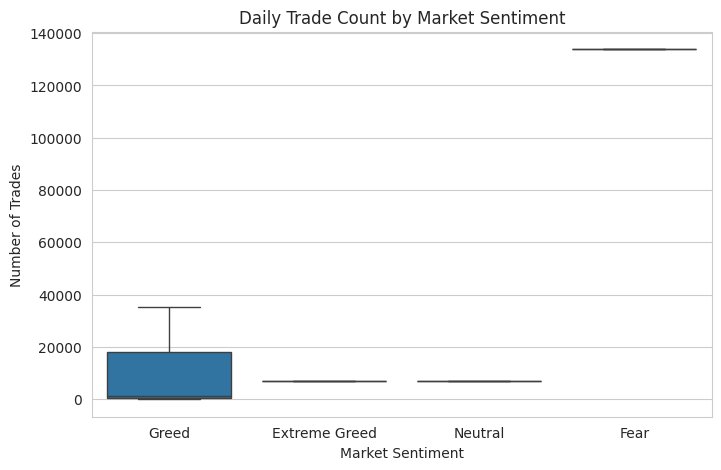

In [ ]:
sns.boxplot(
    data=merged,
    x='classification',
    y='trade_count'
)
plt.title("Daily Trade Count by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")

plt.savefig("outputs/trade_count_by_sentiment.png", bbox_inches='tight')
plt.show()


SANITY CHECK

In [ ]:
import os
os.listdir("outputs")

['pnl_distribution_by_sentiment.png',
 'sharpe_proxy_by_sentiment.png',
 'win_rate_by_sentiment.png',
 'trade_count_by_sentiment.png',
 'volume_by_sentiment.png']